In [2]:
import pandas as pd
import numpy as np
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
!pip3 install seaborn
import seaborn as sns
import random
!pip install anvil-uplink
import anvil.server

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
zsh:1: command not found: pip


In [3]:
key = "EXN4KXVVKRSOCFKNHMM3GTOI-2MPR74A6KBBH2UMX"
anvil.server.connect(key)

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


## Portfolio Profit Prediction

In [4]:
def profit_predictor(currencies_of_interest, starting_balances_list, crypto_usd_fx_list):
    
    from datetime import date
    
    df = pd.read_csv("crypto-markets.csv")
    curr_dic = {}
    for currency in currencies_of_interest:
        curr_dic[currency] = df.loc[df["symbol"].str.lower()==currency,:].copy()
        curr_dic[currency].reset_index(inplace=True, drop=True)

    for currency in currencies_of_interest:
        # Restructure data so that date, open, past market cap(s), past high/low(s) are used to predict close price
        no_rows = curr_dic[currency].shape[0]
        for row in range(no_rows - 1):
            curr_dic[currency].iloc[no_rows - 1 - row, 6] = curr_dic[currency].iloc[no_rows - 1 - row - 1, 6]
            curr_dic[currency].iloc[no_rows - 1 - row, 7] = curr_dic[currency].iloc[no_rows - 1 - row - 1, 7]
            curr_dic[currency].iloc[no_rows - 1 - row, 10] = curr_dic[currency].iloc[no_rows - 1 - row - 1, 10]
        curr_dic[currency].drop(0, axis=0, inplace=True)
        curr_dic[currency].drop(columns=["slug", "symbol", "name", "ranknow", "close_ratio", "spread", "volume"], inplace=True)
        curr_dic[currency].rename(columns={"high": "Prev High", "low": "Prev Low", "market": "Prev Marketcap", "close": "Close"}, inplace=True)

        # Change date column into an integer for number of days since start date
        date_null = date.fromisoformat(curr_dic[currency].iloc[0, 0])
        for row in range(no_rows - 1):
            date = date.fromisoformat(curr_dic[currency].iloc[row, 0])
            curr_dic[currency].iloc[row, 0] = (date - date_null).days
        
    # Split into training and test sets
    try:
        set_dic = {}
        for currency in currencies_of_interest:
            set_dic["train_"+currency], set_dic["val_"+currency] = train_test_split(
                curr_dic[currency][["date", "Prev High", "Prev Low", "open", "Prev Marketcap", "Close"]], 
                test_size=0.33, random_state=1234)
            set_dic["X_train_"+currency] = set_dic["train_"+currency][["date", "Prev High", "Prev Low", "open", "Prev Marketcap"]]
            set_dic["X_test_"+currency] = set_dic["val_"+currency][["date", "Prev High", "Prev Low", "open", "Prev Marketcap"]]
            set_dic["Y_train_"+currency] = set_dic["train_"+currency]["Close"]
            set_dic["Y_test_"+currency] = set_dic["val_"+currency]["Close"]
    except:
        return 0
    
    # Basic linear regression seems to have lower RMSE which is interesting and unexpected
    # Not using accuracy as a performance measure because I am predicting a continuous variable
    model_dic = {}
    for currency in currencies_of_interest:
        model_dic[currency] = LinearRegression()
        model_dic["reg_"+currency] = model_dic[currency].fit(set_dic["X_train_"+currency], set_dic["Y_train_"+currency])
        y_pred_btc = model_dic["reg_"+currency].predict(set_dic["X_test_"+currency])
        #print("RMSE " + currency + ": " + str(mean_squared_error(set_dic["Y_test_"+currency], y_pred_btc) ** 0.5))

    starting_balances = {}
    crypto_usd_fx = {}
    starting_indicators = {}
    predictions = {}
    counter = 0

    for currency in currencies_of_interest:
        starting_balances[currency] = starting_balances_list[counter]
        crypto_usd_fx[currency] = crypto_usd_fx_list[counter]
        counter += 1

        starting_indicators[currency] = curr_dic[currency].iloc[0,:][["date", "Prev High", "Prev Low", "open", "Prev Marketcap"]].to_frame().T
        predictions[currency] = model_dic["reg_"+currency].predict(starting_indicators[currency])

    revenue = sum([crypto_usd_fx[currency]*predictions[currency] for currency in currencies_of_interest])
    cost = sum([crypto_usd_fx[currency]*starting_balances[currency] for currency in currencies_of_interest])
    profit = revenue - cost

    counter = 0
    return profit

## Portfolio Risk Calculator

In [5]:
all_cryptos_df = pd.read_csv("crypto-markets.csv") #Read in project data
all_cryptos_df.head()

cleaned_all_cryptos = all_cryptos_df[all_cryptos_df['date'].str.startswith("2018")] #Only use historical price data from 2018
cleaned_all_cryptos = cleaned_all_cryptos[all_cryptos_df['date'] != "2018-11-30"]
cleaned_all_cryptos['daily_returns'] = (cleaned_all_cryptos['close'] - cleaned_all_cryptos['open']) / (cleaned_all_cryptos['open']) * 100 #create daily percentage returns column
cleaned_all_cryptos.head()

names = cleaned_all_cryptos['name'].unique() #Use unique names to calculate each crypto's beta
names = [x.lower() for x in names]

/var/folders/pl/x69vyh_x4k9d_yy39hrx6q440000gn/T/ipykernel_3984/2413165031.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_all_cryptos = cleaned_all_cryptos[all_cryptos_df['date'] != "2018-11-30"]


In [6]:
def calculate_risk(names, percentages):
    score = 0;
    for i in range(len(names)):
        x = cleaned_all_cryptos[cleaned_all_cryptos['symbol'].str.lower() == names[i].lower()]['daily_returns']
        if (x.empty):
            print(names[i] + ' doesnt exist!')
            return -1
        score += percentages[i] * np.var(x)
    for i in range(len(names)):
        for j in range(len(names)):
            first = cleaned_all_cryptos[cleaned_all_cryptos['symbol'].str.lower() == names[i]]
            second = cleaned_all_cryptos[cleaned_all_cryptos['symbol'].str.lower() == names[j]]
            if (i != j):
                if (first.shape[0] <= second.shape[0]):
                    arr_match = first['date']
                    second = second[second['date'].isin(arr_match)]
                elif (first.shape[0] > second.shape[0]):
                    arr = second['date']
                    first = first[first['date'].isin(arr)]
                if len(second['date']) != len(first['date']):
                    return -1
                score += percentages[i] * percentages[j] * np.cov(first['daily_returns'], second['daily_returns'])[0][1]
    return np.sqrt(score)

## Possible Portfolio Generation

In [7]:
currencies = cleaned_all_cryptos["symbol"].str.lower().unique().tolist()
portfolio_size = 2
risk_portfolios = {}
for trial in range(20):
    curr_temp = random.sample(currencies, 2)
    weight = random.choice([i for i in range(1, 101)])
    risk_lvl = calculate_risk([curr_temp[0], curr_temp[1]], [weight, 100-weight])
    if pd.isna(risk_lvl) or (isinstance(risk_lvl, int) == False and isinstance(risk_lvl, float) == False):
        risk_lvl = -1
    if round(risk_lvl, 1) not in risk_portfolios:
        risk_portfolios[round(risk_lvl, 1)] = [(curr_temp[0], curr_temp[1], weight, 100-weight)]
    else: 
        risk_portfolios[round(risk_lvl, 1)].append((curr_temp[0], curr_temp[1], weight, 100-weight))
print(risk_portfolios)

/var/folders/pl/x69vyh_x4k9d_yy39hrx6q440000gn/T/ipykernel_3984/2536516908.py:23: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(score)


{264.9: [('esco', 'krl', 18, 82)], 291.0: [('ekt', 'veri', 19, 81)], -1: [('skb', 'ori', 38, 62), ('zeus', 'comp', 23, 77), ('uni', 'payx', 4, 96), ('xlq', 'biteur', 42, 58), ('trtl', 'brat', 15, 85), ('grc', 'knt', 14, 86), ('bsc', 'ctl', 25, 75), ('stq', 'tips', 59, 41), ('plx', 'deex', 79, 21), ('stac', 'ixc', 78, 22)], 287.3: [('cfl', 'ldc', 78, 22)], 365.4: [('day', 'proc', 69, 31)], 200.5: [('cob', 'ift', 97, 3)], 258.1: [('eca', 'spk', 88, 12)], 357.8: [('ssp', 'cs', 25, 75)], 841.3: [('whl', 'bitf', 33, 67)], 232.0: [('mth', 'est', 80, 20)], 209.8: [('xbp', 'mft', 9, 91)]}


## Portfolio Selection Per Risk Bucket

In [8]:
final_portfolios = {}
initial_keys = []
for risk in risk_portfolios.keys():
    if risk != -1: initial_keys.append(risk)
    portfolio_options = risk_portfolios[risk]
    crypto_usd_fx_list = [1,1]
    profit_est = -1000
    for portfolio in portfolio_options:
        initial_portfolio_worth = 100
        profit_pred = profit_predictor([portfolio[0], portfolio[1]], [portfolio[2]*.01*initial_portfolio_worth, portfolio[3]*.01*initial_portfolio_worth], crypto_usd_fx_list)
        if profit_pred > profit_est:
            final_portfolios[risk] = portfolio
            profit_est = profit_pred
    profit_est = -1000
print(final_portfolios)

{264.9: ('esco', 'krl', 18, 82), 291.0: ('ekt', 'veri', 19, 81), -1: ('skb', 'ori', 38, 62), 287.3: ('cfl', 'ldc', 78, 22), 365.4: ('day', 'proc', 69, 31), 200.5: ('cob', 'ift', 97, 3), 258.1: ('eca', 'spk', 88, 12), 357.8: ('ssp', 'cs', 25, 75), 841.3: ('whl', 'bitf', 33, 67), 232.0: ('mth', 'est', 80, 20), 209.8: ('xbp', 'mft', 9, 91)}


In [9]:
if -1 in final_portfolios.keys(): del final_portfolios[-1]
for risk in initial_keys:
    scaled = round((((risk - np.min(initial_keys)) / (np.max(initial_keys - np.min(initial_keys)))) * 10) // 1)
    final_portfolios[scaled] = final_portfolios.pop(risk)
print(final_portfolios)

{1: ('cfl', 'ldc', 78, 22), 2: ('ssp', 'cs', 25, 75), 0: ('xbp', 'mft', 9, 91), 10: ('whl', 'bitf', 33, 67)}


## Visualization of Risk

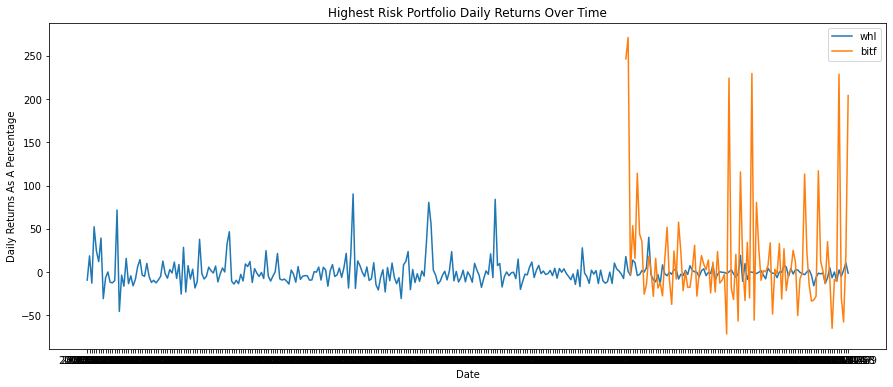

In [10]:
#Create data visualizations for highest risk portfolio using matplotlib

#Take portfolio with highest risk
max_portfolio = [final_portfolios[10][0], final_portfolios[10][1]]

#Draw the portfolio plots
plt.rcParams['figure.figsize'] = (15,6)
plt.title('Highest Risk Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns As A Percentage')

portfolio_cryptos = cleaned_all_cryptos[cleaned_all_cryptos['symbol'].str.lower().isin(max_portfolio)]
for symbol in max_portfolio:
    crypto = portfolio_cryptos[portfolio_cryptos['symbol'].str.lower() == symbol]
    plt.plot(crypto['date'], crypto['daily_returns'], label = symbol)

plt.legend()
plt.show()

In [9]:
@anvil.server.callable
def risk_portfolio(risk):
    try: return final_portfolios[int(risk)]
    except: return ('NA', 'NA', 0, 0)
    
anvil.server.wait_forever()

KeyboardInterrupt: 